## Imports

In [162]:
import sys
import os
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl
import time
import scipy
import pickle

from collections import OrderedDict

from scipy.stats import gaussian_kde
from importlib import reload
import pandas as pd


from mpl_toolkits.mplot3d import Axes3D

mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["text.usetex"] =True

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mho1/.conda/envs/jupy/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mho1/.conda/envs/jupy/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel/kern

In [6]:
import tools.matt_tools as matt

reload(matt)

<module 'tools.matt_tools' from '/home/mho1/halo_cnn/notebooks/tools/matt_tools.py'>

In [7]:
from tools.catalog import Catalog

In [8]:
wdir = '/home/mho1/scratch/halo_cnn'
imdir = '/home/mho1/halo_cnn/paper_images'

# Load Catalogs

In [9]:
pure_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_pure.p'))

contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_med.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_pure.p
Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam_med.p


In [10]:
data_path = os.path.join(wdir, 'data_processed', 'halo_cnn2d_r')
with open(os.path.join(data_path, 'halo_cnn2d_r' + '.p'), 'rb') as f:
    data_proc = pickle.load(f)['data']
#     par_proc = pickle.load(f)['params']

In [11]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw/dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [12]:
cat = contam_cat

rcut = cat.par['aperture'] #Mpc/h
vcut = cat.par['vcut'] #km/s

# Catalog Charateristics

## $M(\sigma)$

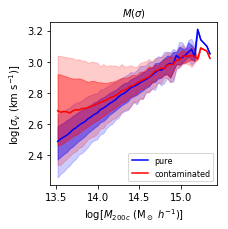

In [10]:
rot = 0

f = plt.figure(figsize=(3,3))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==rot]),
                np.log10(pure_cat.prop['sigv'][pure_cat.prop['rotation']==rot]), 
                percentiles=[35,47],
                n=50, label='pure',ax=ax, log=0, c='b', lw=1.5,names=False)
matt.binnedplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==rot]),
                np.log10(contam_cat.prop['sigv'][contam_cat.prop['rotation']==rot]), 
                percentiles=[35,47],
                n=50, label='contaminated',ax=ax, log=0, c='r',lw=1.5, names=False)

# ax.set_xlim(14,15.3)
# ax.set_ylim(2.3,3.3)

plt.xlabel(r'$\log[M_{200c}\ ($M$_\odot\ h^{-1})]$', fontsize=10)
plt.ylabel(r'$\log[\sigma_v\ ($km s$^{-1})]$', fontsize=10)
plt.title('$M(\sigma)$', fontsize=10)
ax.legend(loc=4, fontsize=8)

# plt.tight_layout()

# f.savefig(os.path.join(imdir, 'M_sig.pdf'),bbox_inches='tight')

In [158]:
model_name = 'halo_cnn2d_r'
model_num = 56

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

with open(os.path.join(data_dir, model_name_save, model_name_save + '_regr.p'),'rb') as f:
    regr = pickle.load(f)
print(regr)

rel_mass=10**15
train_min = 10**14.5

{'pure': {'model': array([(0.36581767, 3.0362322, -769.95966, 0.06891802)],
      dtype=[('coef', '<f4'), ('intercept', '<f4'), ('R^2', '<f4'), ('scatter', '<f4')]), 'pred': array([(13.500017,  1.3514581e+01, False,  True),
       (13.500017,  1.3660312e+01, False,  True),
       (13.500044,  1.3552072e+01, False,  True), ...,
       (15.236311,  5.8602929e-02,  True, False),
       (15.309439,  4.5236440e-26, False, False),
       (15.333447, -1.1214144e+22, False, False)],
      dtype=[('logmass', '<f4'), ('logmass_pred', '<f4'), ('in_train', '?'), ('in_test', '?')])}, 'contam': {'model': array([(0.24116582, 3.0010664, -508.916, 0.10379335)],
      dtype=[('coef', '<f4'), ('intercept', '<f4'), ('R^2', '<f4'), ('scatter', '<f4')]), 'pred': array([(13.500003,  1.4366750e+01, False,  True),
       (13.500017,  1.4175947e+01, False,  True),
       (13.500017,  1.5047657e+01, False,  True), ...,
       (15.236311,  4.4630586e-29,  True, False),
       (15.309439, -4.9710731e+17, False, Fa

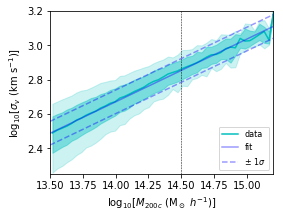

In [12]:
rot = 0

f = plt.figure(figsize=(4,3))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==rot]),
                np.log10(pure_cat.prop['sigv'][pure_cat.prop['rotation']==rot]), 
                percentiles=[35,47],
                n=50, label='data',ax=ax, log=0, c='c', lw=1.5,names=False)

ax.set_xlim(13.5,15.2)
ax.set_ylim(2.25,3.2)

plt.xlabel(r'$\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$', fontsize=10)
plt.ylabel(r'$\log_{10}[\sigma_v\ ($km s$^{-1})]$', fontsize=10)
# plt.title('Pure M-$\sigma$', fontsize=10)

one_to_one = np.arange(11)*(np.log10(pure_cat.prop['M200c'].max()) - \
                            np.log10(pure_cat.prop['M200c'].min()))/10. + \
             np.log10(pure_cat.prop['M200c'].min())

fit_y = (one_to_one - np.log10(rel_mass)) * regr['pure']['model']['coef'] + regr['pure']['model']['intercept']
ax.plot(one_to_one,fit_y,'b',label='fit',alpha=0.4)
ax.plot(one_to_one,fit_y - regr['pure']['model']['scatter'], 'b', 
        linestyle='--', label='$\pm\ 1\sigma$', alpha=0.4)
ax.plot(one_to_one,fit_y + regr['pure']['model']['scatter'], 'b', 
        linestyle='--',alpha=0.4)

ax.axvline(x=np.log10(train_min), linestyle='--', color='k', linewidth=0.5)


ax.legend(loc=4, fontsize=8)

# plt.tight_layout()

f.savefig(os.path.join(imdir, 'M_sig_pure.pdf'),bbox_inches='tight')

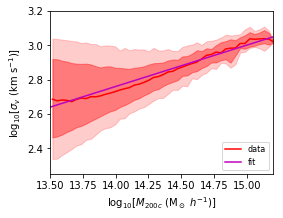

In [10]:
rot = 0

f = plt.figure(figsize=(4,3))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==rot]),
                np.log10(contam_cat.prop['sigv'][contam_cat.prop['rotation']==rot]), 
                percentiles=[35,47],
                n=50, label='data',ax=ax, log=0, c='r', lw=1.5,names=False)

ax.set_xlim(13.5,15.2)
ax.set_ylim(2.25,3.2)

plt.xlabel(r'$\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$', fontsize=10)
plt.ylabel(r'$\log_{10}[\sigma_v\ ($km s$^{-1})]$', fontsize=10)
# plt.title('Contaminated M-$\sigma$', fontsize=10)

one_to_one = np.arange(11)*(np.log10(contam_cat.prop['M200c'].max()) - \
                            np.log10(contam_cat.prop['M200c'].min()))/10. + \
             np.log10(contam_cat.prop['M200c'].min())

fit_y = (one_to_one - np.log10(rel_mass)) * regr['contam']['model']['coef'] + regr['contam']['model']['intercept']
ax.plot(one_to_one,fit_y,'m',label='fit')
# ax.plot(one_to_one,fit_y - regr['contam']['model']['scatter'], 'm', linestyle='--', label='$\pm\ 1\sigma$')
# ax.plot(one_to_one,fit_y + regr['contam']['model']['scatter'], 'm', linestyle='--')

# ax.axvline(x=np.log10(train_min), linestyle='--', color='k', linewidth=0.5)


ax.legend(loc=4, fontsize=8)

# plt.tight_layout()

f.savefig(os.path.join(imdir, 'M_sig_contam.png'),bbox_inches='tight', dpi=300)

## HMF

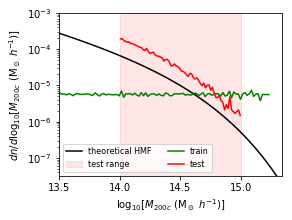

In [180]:
f = plt.figure(figsize=(4,3))
ax3 = f.add_subplot(111)

ax3.plot(x_hmf_M200c,y_hmf_M200c, label='theoretical HMF', c='k')

test_range=(14,15)
ax3.axvspan(*test_range,
           alpha=0.1, color='r', label='test range')
n = matt.histplot(data_proc['logmass'][data_proc['in_train'] & (data_proc['fold']!=0)], 
                  n=100, log=1, box=True, label='train', c='g', ax=ax3)
_ = matt.histplot(data_proc['logmass'][data_proc['in_test'] & \
                                       (data_proc['logmass'] > test_range[0]) & \
                                       (data_proc['logmass'] < test_range[1])
                                      ], 
                  n=70, log=1, box=True, label='test', c='r', ax=ax3, func=lambda x: x)

ax3.set_xlabel(r'$\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$', fontsize=10)
ax3.set_ylabel('$dn/d\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$',fontsize=10)
ax3.set_ylim(10**-7.5, 10**-3)
ax3.set_xlim(data_proc['logmass'][data_proc['in_train']].min(),
             data_proc['logmass'][data_proc['in_train']].max())

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc=3, fontsize=8)
# ax3.legend(ncol=2, loc=3, fontsize=8)

ax3.set_xlim(xmin=data_proc['logmass'].min(), xmax=data_proc['logmass'].max())
f.savefig(os.path.join(imdir, 'hmf.pdf'),bbox_inches='tight')

## PDF binned mass

13.500003068051694
13.958364119662958
14.416725171274223
14.875086222885486


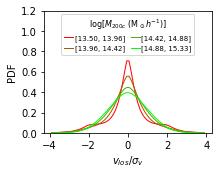

In [149]:
rot = 0
mbins = 4
vbins = 70
label=''

vedge = 4

cat = contam_cat
# cat = cat[np.random.choice(range(len(cat)),10000,replace=False)]

f = plt.figure(figsize=(3,2.25))
ax = f.add_subplot(111)


minc = (np.log10(cat.prop['M200c'].max()/cat.prop['M200c'].min()))/mbins
mi = np.log10(cat.prop['M200c'].min())

colors = [(1-i, i, 0) for i in np.linspace(0,1,mbins)]
i=0

for mi in (np.log10(cat.prop['M200c'].min()) + minc*np.arange(mbins)):
    print(mi)

    cat_bin = np.where((cat.prop['M200c'] >= 10**mi ) & (cat.prop['M200c'] <= 10**(mi+minc)))[0]


    histvals = np.zeros(vbins)
    for j in cat_bin:
        clusv = cat.gal[j]['vlos']

        clusv = clusv/clusv.std()
        
        histvals += np.histogram(clusv, bins=vbins, range=(-vedge,vedge), density=True)[0]
    
    histvals /= len(cat_bin)

    ax.plot(
        np.linspace(-vedge,vedge, vbins+2)[1:-1],
        histvals,
        label=label + "[%.2f, %.2f]" % (mi,mi + minc),
        c = colors[i],
        lw=1
    )
    i+=1
    
plt.xlabel(r'$v_{los}/\sigma_v$', fontsize=10)
plt.ylabel(r'PDF', fontsize=10)
plt.ylim(0,1.2)
  
l = plt.legend(ncol=2, loc=9, title='$\log[M_{200c}\ ($M$_\odot h^{-1})]$', fontsize=7,
               handletextpad=0.25, columnspacing=0.75, handlelength=1.3
              )
l.get_title().set_fontsize(8)

# plt.tight_layout()

f.savefig(os.path.join(imdir, 'pdf_binmass.pdf'),bbox_inches='tight')

## Random cluster

host id: 11833844165.0
rotation: 2.0
log(M_200c): 13.793413180703604


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


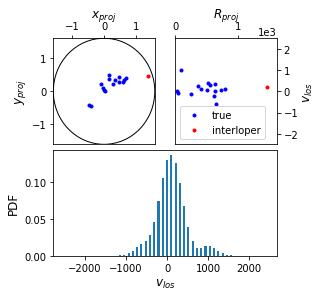

In [9]:
i = np.random.randint(0, len(contam_cat))
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]
# i = 47804

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))


rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

f = plt.figure(figsize=[4,4])
gs = mpl.gridspec.GridSpec(2,2, hspace=0.05)


ax1 = f.add_subplot(gs[0,0])

x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r')
circle = plt.Circle((0, 0), radius = rcut, edgecolor='k', facecolor='none')
ax1.add_artist(circle)

ax1.set_xlim(-rcut,rcut)
ax1.set_ylim(-rcut,rcut)
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax1.set_xlabel('$x_{proj}$', fontsize=12)
ax1.set_ylabel('$y_{proj}$', fontsize=12)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

ax2 = f.add_subplot(gs[0,1])
x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

ax2.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
ax2.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')
plt.legend()

ax2.set_xlim(0,rcut)
ax2.set_ylim(-vcut,vcut)
ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.set_xlabel('$R_{proj}$', fontsize=12)
ax2.set_ylabel('$v_{los}$', fontsize=12)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax3 = f.add_subplot(gs[1,:])
kde = gaussian_kde(contam_cat.gal[i]['vlos'])
pos = np.arange(-vcut,vcut, vcut/(48/2.))
y = kde(pos)
y /= np.sum(y)

# y = np.histogram(contam_cat.gal[i]['vlos'], 48, density=True)[0]
# pos = np.linspace(-vcut,vcut, 48+2)[1:-1]
ax3.bar(pos, y, width=50)

#ax3.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax3.set_xlabel('$v_{los}$', fontsize=12)
ax3.set_ylabel('PDF', fontsize=12)

# f.suptitle('$\log[M_{200c}\ ($M$_\odot h^{-1})] =$' + str(np.log10(contam_cat.prop['M200c'][i]))[0:5], 
#            y=1.07,fontsize=14)

plt.tight_layout()

# f.savefig(os.path.join(img_savedir,'MD_cluster.pdf'))

host id: 11833844165.0
rotation: 2.0
log(M_200c): 13.793413180703604


Text(0,0.5,'$v_{los}$ (km s$^{-1}$)')

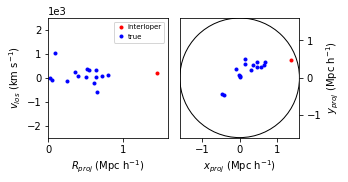

In [10]:
# i = np.random.randint(0, len(contam_cat))
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]
# i = 47804

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))


rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

f = plt.figure(figsize=[4.5,3])
gs = mpl.gridspec.GridSpec(1,2, wspace=0.1)


ax1 = f.add_subplot(gs[0,1])

x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r')
circle = plt.Circle((0, 0), radius = rcut, edgecolor='k', facecolor='none')
ax1.add_artist(circle)


ax1.set_aspect(aspect='equal',adjustable='box', anchor='W')
ax1.set_xlim(-rcut,rcut)
ax1.set_ylim(-rcut,rcut)
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax1.set_xlabel('$x_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$y_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

ax2 = f.add_subplot(gs[0,0])
x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

ax2.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')
ax2.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
l = ax2.legend(fontsize=7,
               handletextpad=0.25, columnspacing=0.75, handlelength=1.3
              )


ax2.set_aspect(aspect=rcut/(2*vcut),adjustable='box', anchor='E')
ax2.set_xlim(0,rcut)
ax2.set_ylim(-vcut,vcut)
ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.set_xlabel('$R_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)


# f.suptitle('$\log[M_{200c}\ ($M$_\odot h^{-1})] = $' + str(np.log10(contam_cat.prop['M200c'][i]))[0:5], 
#            y=1.025,fontsize=14)

# plt.tight_layout()

# f.savefig(os.path.join(imdir,'ex_cluster.pdf'),bbox_inches='tight')

host id: 11848439621.0
rotation: 1.0
log(M_200c): 13.581653887176893


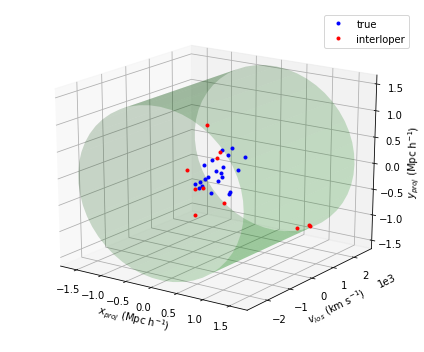

In [14]:
i = np.random.randint(0, len(contam_cat))

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))


rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

f = plt.figure(figsize=(6,5))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0.1, height_ratios=[1,1])

ax1 = f.add_subplot(111, projection='3d')

# Scatter graph
x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['vlos']
z = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
        y[contam_cat.gal[i]['true_memb']==1],
        z[contam_cat.gal[i]['true_memb']==1],
        '.', c='b', label='true')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
        y[contam_cat.gal[i]['true_memb']!=1],
        z[contam_cat.gal[i]['true_memb']!=1],
        '.', c='r', label='interloper')

# Cylinder

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,rcut,vcut)

# # Draw parameters
rstride = 50
cstride = 2
ax1.plot_surface(Xc, Zc, Yc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')
# ax.plot_surface(Xc, -Yc, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')

ax1.view_init(20,-55)

# ax1.set_xlim(-5,5)

ax1.legend()
ax1.set_xlabel("$x_{proj}$ (Mpc h$^{-1}$)")
ax1.set_ylabel("$v_{los}$ (km s$^{-1}$)")
ax1.set_zlabel("$y_{proj}$ (Mpc h$^{-1}$)")
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))


plt.tight_layout()

host id: 11940016995.0
rotation: 1.0
log(M_200c): 14.331589240955136


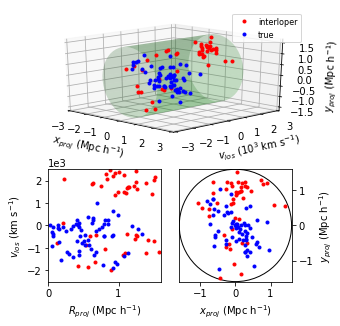

In [174]:
i = np.random.choice(np.argwhere(contam_cat.prop['M200c']>10**14.1).flatten())

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))


rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

f = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2,2, wspace=0.1, height_ratios=[1.2,1])

ax1 = f.add_subplot(gs[0,:], projection='3d',
                    adjustable='box',
                    aspect=0.5
                   )

# Scatter graph
x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['vlos']/10**3
z = contam_cat.gal[i]['yproj']
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
        y[contam_cat.gal[i]['true_memb']!=1],
        z[contam_cat.gal[i]['true_memb']!=1],
        '.', c='r', label='interloper')
ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
        y[contam_cat.gal[i]['true_memb']==1],
        z[contam_cat.gal[i]['true_memb']==1],
        '.', c='b', label='true')

# Cylinder

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,rcut,vcut/10**3)

# # Draw parameters
rstride = 50
cstride = 2
ax1.plot_surface(Xc, Zc, Yc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')
# ax.plot_surface(Xc, -Yc, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')

ax1.view_init(20,-45)

ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)

# for tick in ax1.get_yticklabels():
#     tick.set_rotation(-30)

ax1.legend(fontsize=8)
ax1.set_xlabel("$x_{proj}$ (Mpc h$^{-1}$)", fontsize=10, labelpad=8)
ax1.set_ylabel("$v_{los}$ ($10^3$ km s$^{-1}$)", fontsize=10, labelpad=8)
ax1.set_zlabel("$y_{proj}$ (Mpc h$^{-1}$)", fontsize=10)
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))





ax2 = f.add_subplot(gs[1,0])
x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

ax2.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')
ax2.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
# l = ax2.legend(fontsize=7,
#                handletextpad=0.25, columnspacing=0.75, handlelength=1.3
#               )


ax2.set_aspect(aspect=rcut/(2*vcut),adjustable='box', anchor='E')
ax2.set_xlim(0,rcut)
ax2.set_ylim(-vcut,vcut)
ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.set_xlabel('$R_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)


ax3 = f.add_subplot(gs[1,1])

x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['yproj']

ax3.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r')
ax3.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b')
circle = plt.Circle((0, 0), radius = rcut, edgecolor='k', facecolor='none')
ax3.add_artist(circle)


ax3.set_aspect(aspect='equal',adjustable='box', anchor='W')
ax3.set_xlim(-rcut,rcut)
ax3.set_ylim(-rcut,rcut)
ax3.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax3.set_xlabel('$x_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax3.set_ylabel('$y_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')


f.savefig(os.path.join(imdir,'ex_cluster.pdf'),bbox_inches='tight')

## KDE example

# 42491
log[M_{200c}] = 13.735


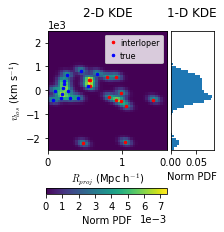

In [13]:


i = np.random.randint(len(cat))
bandwidth=0.35
par = {'shape':(48,48)}


print('#',i)
print('log[M_{200c}] = ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6])
#1D KDE
kde = gaussian_kde(contam_cat.gal[i]['vlos'], bw_method=0.25)
v_pos = np.linspace(-vcut, vcut, 48 + 1)
v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

kdeval_1d = kde(v_pos)
kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


#2D KDE
a_pos = np.linspace(0, cat.par['aperture'], 48 + 1)
a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

mesh = np.meshgrid(a_pos,v_pos)
mesh = np.flip(mesh,0)
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, 0.15)

# sample kde at fixed intervals
kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# normalize input
kdeval_2d /= kdeval_2d.sum()



# plot
f = plt.figure(figsize=(4,3))
gs = mpl.gridspec.GridSpec(2,3, wspace=0.05,hspace=0.6, width_ratios=[1.2,2.8,1],height_ratios=[19,1])


# 2D
ax1 = f.add_subplot(gs[0,0:2])

im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
               extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


ax1.plot(memb[1][cat.gal[i]['true_memb']!=1], 
         -memb[0][cat.gal[i]['true_memb']!=1],
         'r.',label='interloper', markersize=5)
ax1.plot(memb[1][cat.gal[i]['true_memb']==1], 
         -memb[0][cat.gal[i]['true_memb']==1],
         'b.',label='true', markersize=5)

ax1.set_ylim(-cat.par['vcut'], cat.par['vcut'])

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=cat.par['aperture']/(2*vcut),adjustable='box', anchor='E')
ax1.set_title('2-D KDE', y=1.07)
ax1.set_xlabel('$R_{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)

l = ax1.legend(fontsize=8,
               handletextpad=0.25, columnspacing=0.75, handlelength=1.3
              )


# 1D
ax2 = f.add_subplot(gs[0,2])
ax2.barh(v_pos, kdeval_1d, height=100)

ax2.set_ylim(-cat.par['vcut'], cat.par['vcut'])

ax2.set_title('1-D KDE', y=1.07)
ax2.set_xlabel('Norm PDF', fontsize=10)
# ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax2.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))

# Colorbar
ax3 = f.add_subplot(gs[1,1])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=kdeval_2d.min(), vmax=kdeval_2d.max())

cb = mpl.colorbar.ColorbarBase(label='Norm PDF', ax=ax3, norm=norm, orientation='horizontal')
cb.set_label('Norm PDF',fontsize=10)
cb.formatter.set_powerlimits((0, 1))
cb.update_ticks()



# plt.suptitle('$\log[M_{200c}\ ($M$_\odot h^{-1})] = $' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6], fontsize=14, y=1.05)

# plt.tight_layout()

# f.savefig(os.path.join(imdir,'ex_kde.pdf'),bbox_inches='tight')

# 79119
log[M_{200c}] = 14.219


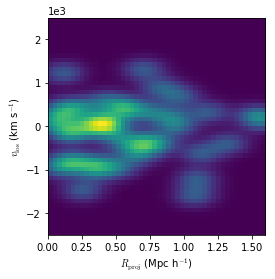

In [136]:


# i = np.random.randint(len(cat))
bandwidth=0.25
par = {'shape':(48,48)}


print('#',i)
print('log[M_{200c}] = ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6])
#1D KDE
# kde = gaussian_kde(contam_cat.gal[i]['vlos'], bw_method=0.25)
# v_pos = np.linspace(-vcut, vcut, 48 + 1)
# v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

# kdeval_1d = kde(v_pos)
# kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


#2D KDE
a_pos = np.linspace(0, cat.par['aperture'], 48 + 1)
a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

mesh = np.meshgrid(a_pos,v_pos)
mesh = np.flip(mesh,0)
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# normalize input
kdeval_2d /= kdeval_2d.sum()



# plot
f = plt.figure(figsize=(4,4))
gs = mpl.gridspec.GridSpec(1,1)#, wspace=0.05,hspace=0.6, width_ratios=[1.2,2.8,1],height_ratios=[19,1])


# 2D
ax1 = f.add_subplot(gs[0])

im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
               extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


# ax1.plot(memb[1][cat.gal[i]['true_memb']!=1], 
#          -memb[0][cat.gal[i]['true_memb']!=1],
#          'r.',label='interloper', markersize=5)
# ax1.plot(memb[1][cat.gal[i]['true_memb']==1], 
#          -memb[0][cat.gal[i]['true_memb']==1],
#          'b.',label='true', markersize=5)

ax1.set_ylim(-cat.par['vcut'], cat.par['vcut'])

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=cat.par['aperture']/(2*vcut),adjustable='box', anchor='E')
# ax1.set_title('2-D KDE', y=1.07)
ax1.set_xlabel('$R_\mathrm{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)

f.savefig(os.path.join(imdir,'input_2d.eps'),bbox_inches='tight')

# 79119
log[M_{200c}] = 14.219


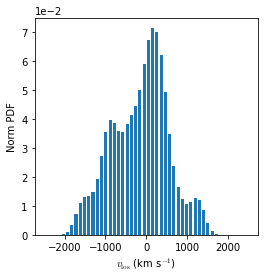

In [135]:


# i = np.random.randint(len(cat))
bandwidth=0.25
par = {'shape':(48,48)}


print('#',i)
print('log[M_{200c}] = ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6])
# 1D KDE
kde = gaussian_kde(contam_cat.gal[i]['vlos'], bw_method=0.25)
v_pos = np.linspace(-vcut, vcut, 48 + 1)
v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

kdeval_1d = kde(v_pos)
kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


#2D KDE
# a_pos = np.linspace(0, cat.par['aperture'], 48 + 1)
# a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

# mesh = np.meshgrid(a_pos,v_pos)
# mesh = np.flip(mesh,0)
# sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

# memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
# memb[0,:] = cat.gal[i]['vlos']
# memb[1,:] = cat.gal[i]['Rproj']

# # initialize a gaussian kde from galaxies
# kde = gaussian_kde(memb, bandwidth)

# # sample kde at fixed intervals
# kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# # normalize input
# kdeval_2d /= kdeval_2d.sum()



# plot
f = plt.figure(figsize=(4,4))
gs = mpl.gridspec.GridSpec(1,1)#, wspace=0.05,hspace=0.6, width_ratios=[1.2,2.8,1],height_ratios=[19,1])


# 1D
ax2 = f.add_subplot(gs[0])
ax2.bar(v_pos, kdeval_1d, width=75)

# ax2.set_ylim(-cat.par['vcut'], cat.par['vcut'])

# ax2.set_title('1-D KDE', y=1.07)
ax2.set_ylabel('Norm PDF', fontsize=10)
# ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position('right')
# ax2.set_yticks([])

ax2.set_xlabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)
ax2.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))


# ax1.plot(memb[1][cat.gal[i]['true_memb']!=1], 
#          -memb[0][cat.gal[i]['true_memb']!=1],
#          'r.',label='interloper', markersize=5)
# ax1.plot(memb[1][cat.gal[i]['true_memb']==1], 
#          -memb[0][cat.gal[i]['true_memb']==1],
#          'b.',label='true', markersize=5)

# ax1.set_ylim(-cat.par['vcut'], cat.par['vcut'])

f.savefig(os.path.join(imdir,'input_1d.eps'),bbox_inches='tight')

# 118707
log[M_{200c}] = 13.670
# 238261
log[M_{200c}] = 13.958
# 162914
log[M_{200c}] = 14.151
# 84626
log[M_{200c}] = 14.526
# 259480
log[M_{200c}] = 14.861
# 262032
log[M_{200c}] = 15.236


Text(0.5,0,'$v_{los}$ (km s$^{-1}$)')

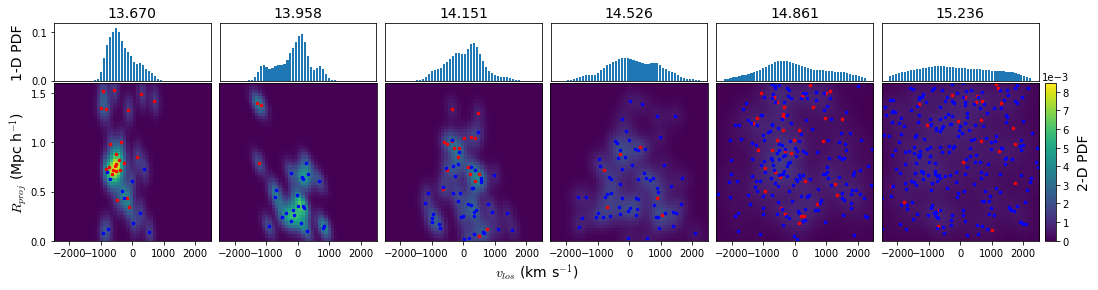

In [23]:
N = 6

bandwidth=0.25
par = {'shape':(48,48)}

hratio = 1/2.75
fudge = 1.1

f = plt.figure(figsize=(N*3,4))
gs = mpl.gridspec.GridSpec(2,N+1, wspace=0.025,hspace=0.025, 
                           height_ratios=[1,1/hratio],
                           width_ratios=[15]*N + [1]
                          )

hratio*=fudge

store_memb = []
store_1d = []
store_2d = []

temp = np.linspace(np.log10(cat.prop['M200c']).min(),np.log10(cat.prop['M200c']).max(),
                  N+1)
store_i = [np.random.choice(np.where((np.log10(cat.prop['M200c'])>=temp[i])&
                                     (np.log10(cat.prop['M200c'])<temp[i+1]))[0])
          for i in range(N)]

for j in range(N):
    
    i = store_i[j]
    print('#',i)
    print('log[M_{200c}] = ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6])
    
    #1D KDE
    kde = gaussian_kde(contam_cat.gal[i]['vlos'], bw_method=bandwidth)
    v_pos = np.linspace(-vcut, vcut, 48 + 1)
    v_pos = np.array([np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)])

    kdeval_1d = kde(v_pos)
    kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


    #2D KDE
    a_pos = np.linspace(0, cat.par['aperture'], 48 + 1)
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

    memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
    memb[0,:] = cat.gal[i]['vlos']
    memb[1,:] = cat.gal[i]['Rproj']

    # initialize a gaussian kde from galaxies
    kde = gaussian_kde(memb, bandwidth)

    # sample kde at fixed intervals
    kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

    # normalize input
    kdeval_2d /= kdeval_2d.sum()

    kdeval_2d = np.rot90(kdeval_2d)
    
    
    store_i.append(i)
    store_memb.append(memb)
    store_1d.append(kdeval_1d)
    store_2d.append(kdeval_2d)


max_1d = 1.1*max([x.max() for x in store_1d])
max_2d = max([x.max() for x in store_2d])
    
for j in range(N):
    # plot
    
    i = store_i[j]
    memb = store_memb[j]
    kdeval_1d = store_1d[j]
    kdeval_2d = store_2d[j]

    # 2D
    ax1 = f.add_subplot(gs[1,j])
    

    im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
                   extent=[-cat.par['vcut'], cat.par['vcut'], 0, cat.par['aperture']],
                   vmin=0, vmax=max_2d
                  )


    ax1.plot(memb[0][cat.gal[i]['true_memb']!=1],
             memb[1][cat.gal[i]['true_memb']!=1], 
             'r.',label='interloper', markersize=5)
    ax1.plot(memb[0][cat.gal[i]['true_memb']==1],
             memb[1][cat.gal[i]['true_memb']==1],
             'b.',label='true', markersize=5)

    ax1.set_yticks(np.linspace(0,1.5,4))
    if j>0: ax1.set_yticks([])
        
    ax1.set_xlim(-cat.par['vcut'], cat.par['vcut'])
    ax1.set_ylim(0, cat.par['aperture'])

    ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
    ax1.set_aspect(aspect=(2*vcut)/cat.par['aperture'],adjustable='box', anchor='N')
#     ax1.set_title('2-D KDE', y=1.07)
    
    if j==0: ax1.set_ylabel('$R_{proj}$ (Mpc h$^{-1}$)', fontsize=14, labelpad=0)
        
#     ax1.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)

#     l = ax1.legend(fontsize=8,
#                    handletextpad=0.25, columnspacing=0.75, handlelength=1.3
#                   )


    # 1D
    ax2 = f.add_subplot(gs[0,j])
    ax2.bar(-v_pos, kdeval_1d, width=75)

#     ax2.set_ylim(-cat.par['vcut'], cat.par['vcut'])

#     ax2.set_title('1-D KDE', y=1.07)
#     ax2.set_xlabel('Norm PDF', fontsize=10)
    # ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)
    # ax2.yaxis.tick_right()
    # ax2.yaxis.set_label_position('right')
    ax2.set_ylim(0,max_1d)
    ax2.set_xticks([])
#     ax2.set_yticks(np.linspace(0,0.15,2))
    if j>0: ax2.set_yticks([])
        
        
    if j==0: ax2.set_ylabel('1-D PDF', fontsize=14, labelpad=6)
        
    ax2.set_aspect(aspect=(2*vcut)/max_1d*hratio,adjustable='box', anchor='S')
    
    
    ax2.set_title(str(np.log10(cat.prop.loc[i,'M200c']))[0:6], fontsize=14)

#     ax2.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))

# Colorbar

    
ax3 = f.add_subplot(gs[1,N])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=max_2d)

cb = mpl.colorbar.ColorbarBase(label='2-D PDF', ax=ax3, norm=norm, orientation='vertical')
cb.set_label('2-D PDF',fontsize=14, labelpad=8)
cb.formatter.set_powerlimits((0, 1))#, x=1.1)
cb.update_ticks()

cb.ax.yaxis.offsetText.set_horizontalalignment('center')

f.text(0.5, 0.0, '$v_{los}$ (km s$^{-1}$)', fontsize=14, ha='center')

# f.savefig(os.path.join(imdir,'ex_kde.pdf'),bbox_inches='tight')

# CNN

## Architecture

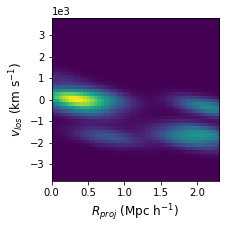

In [23]:
v_pos = np.linspace(-vcut, vcut, 48 + 1)
v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

a_pos = np.linspace(0, cat.par['aperture'], 48 + 1)
a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]


mesh = np.meshgrid(a_pos,v_pos)
mesh = np.flip(mesh,0)
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# normalize input
kdeval_2d /= kdeval_2d.sum()



# plot
s = 1

f, ax1 = plt.subplots(figsize=(3*s,3*s))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0., width_ratios=[2,1],height_ratios=[19,1])


# 2D
# ax1 = f.add_subplot()

im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
               extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


ax1.set_ylim(-cat.par['vcut'], cat.par['vcut'])

ax1.set_xlabel('$R_{proj}$ (Mpc h$^{-1}$)', fontsize=12*s)
ax1.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=12*s)


ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))

f.savefig(os.path.join(imdir,'arch_2dkde.png'),bbox_inches='tight', dpi=1000)

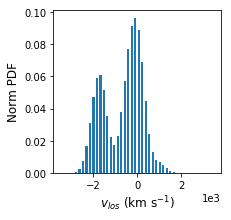

In [24]:
f, ax2 = plt.subplots(figsize=(3,3))

ax2.bar(v_pos, kdeval_1d, width=100)

ax2.set_xlim(-cat.par['vcut'], cat.par['vcut'])


ax2.set_ylabel('Norm PDF', fontsize=12)
ax2.set_xlabel('$v_{los}$ (km s$^{-1}$)', fontsize=12)


ax2.ticklabel_format(style='sci',axis='x', scilimits=(-1,1))

f.savefig(os.path.join(imdir,'arch_1dkde.png'),bbox_inches='tight', dpi=1000)

# Loss curves

In [163]:
# 1d
model_name = 'halo_cnn1d_r'
model_num = 144

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

data_loss_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '_loss.npy'), 
                    encoding='latin1')

#2d
model_name = 'halo_cnn2d_r'
model_num = 32

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

data_loss_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '_loss.npy'), 
                    encoding='latin1')

In [164]:
data_loss_1d[fold].view('<f4')

NameError: name 'fold' is not defined

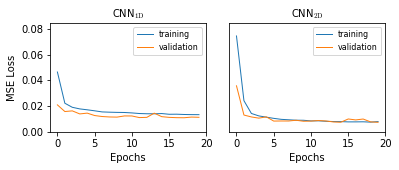

In [182]:
fold = 3

max_loss = max(data_loss_1d[fold].view('<f4').max(), 
               data_loss_2d[fold].view('<f4').max())

f = plt.figure(figsize=[6,2])
gs = mpl.gridspec.GridSpec(1,2, wspace=0.15)


ax1 = f.add_subplot(gs[0,0])

ax1.plot(data_loss_1d['train'][fold], label='training', linewidth=1)             
ax1.plot(data_loss_1d['val'][fold], label='validation', linewidth=1)

ax1.set_yticks(np.linspace(0,0.1,6))
ax1.set_ylim(0,max_loss + 0.01)
ax1.set_ylabel('MSE Loss')
ax1.set_xlabel('Epochs')
ax1.set_title('CNN$_\mathrm{1D}$', fontsize=10)
# ax1.set_xticks([])
# ax1.tick_params(axis = 'both', which = 'major', labelsize = 7)

ax1.legend(fontsize=8)

ax2 = f.add_subplot(gs[0,1])

ax2.plot(data_loss_2d['train'][fold], label='training', linewidth=1)             
ax2.plot(data_loss_2d['val'][fold], label='validation', linewidth=1)
ax2.set_ylim(0,max_loss + 0.01)
ax2.set_yticks([])
ax2.set_xlabel('Epochs')
# ax2.set_ylabel('MSE Loss')
ax2.legend(fontsize=8)
ax2.set_title('CNN$_\mathrm{2D}$', fontsize=10)

f.savefig(os.path.join(imdir,'loss.pdf'),bbox_inches='tight', dpi=300)

# Results

## 1D

In [153]:
model_name = 'halo_cnn1d_r'
model_num = 152

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']


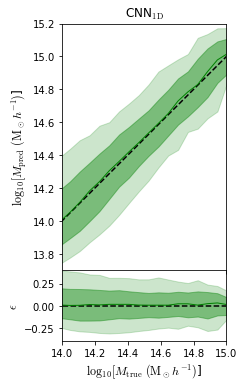

In [154]:
f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'], cnn_dat['logmass_pred'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='g'
            )
ax1.set_ylabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err = cnn_dat['logmass_pred'] - cnn_dat['logmass_test']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='g', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-0.5,0,1])


ax1.set_title('CNN$_\mathrm{1D}$', fontsize=12)

plt.tight_layout()

f.savefig(os.path.join(imdir,'pred_1d.pdf'),bbox_inches='tight', dpi=300)

## 2D

In [144]:
model_name = 'halo_cnn2d_r'
model_num = 67 # bwidth=0.25
# model_num=57 # bwidth=0.15


data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

print(cnn_par['bandwidth'])

0.25


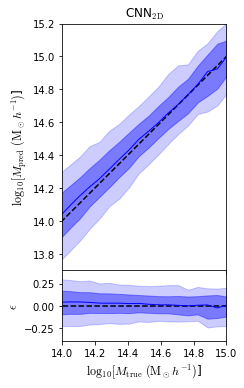

In [147]:
s=1

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

# ax1.plot(cnn_dat['logmass_test'][cnn_dat['logmass_test']>15.05],
#          cnn_dat['logmass_pred'][cnn_dat['logmass_test']>15.05],'.', c='r'
#         )
matt.binnedplot(cnn_dat['logmass_test'], cnn_dat['logmass_pred'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='b'
            )


ax1.set_ylabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err = cnn_dat['logmass_pred'] - cnn_dat['logmass_test']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='b', errorbar=False, names=False, 
                log=0)#, err_lines=True, linestyle='--')

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-1,0,1])


ax1.set_title('CNN$_\mathrm{2D}$', fontsize=12)

plt.tight_layout()

f.savefig(os.path.join(imdir,'pred_2d.pdf'),bbox_inches='tight', dpi=300)

## SDM

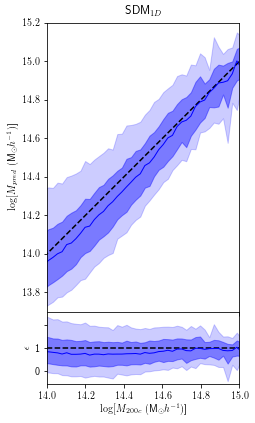

In [17]:
model_name = 'halo_sdm1d'
model_num = 20

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
sdm_par = sdm_dat['params']

# sdm_dat = np.load('/home/mho1/scratch/halo_cnn/mich/sdm_mich_preds.npy')
# sdm_dat = sdm_dat.reshape(1)[0]

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

# plt.figure(figsize=(5,5))
# for i in range(int(max(sdm_dat['fold']))):
#     plt.plot(sdm_dat['logmass_test'][sdm_dat['fold']==i], 
#              sdm_dat['logmass_pred'][sdm_dat['fold']==i],
#              '.', markersize=2, label='fold '+str(i))
# plt.xlim(14,15.2)
# plt.ylim(13.5,15.2)

# plt.xlabel('M200c')
# plt.ylabel('M_pred')
# plt.title('SDM |v|')
# plt.legend()

s=1

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

# ax1.plot(cnn_dat['logmass_test'][cnn_dat['logmass_test']>15.05],
#          cnn_dat['logmass_pred'][cnn_dat['logmass_test']>15.05],'.', c='r'
#         )
matt.binnedplot(sdm_dat['logmass_test'], sdm_dat['logmass_pred'], n=50, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='b'
            )


ax1.set_ylabel(r'$\log[M_{pred}\ ($M$_\odot h^{-1})$]',fontsize=10)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')

pred_err = sdm_dat['logmass_pred'] - sdm_dat['logmass_test']
# pred_err = (10.**sdm_dat['logmass_pred'])/(10.**sdm_dat['logmass_test']) - 1.

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(sdm_dat['logmass_test'],pred_err,n=50, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='b', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=10)
ax2.set_xlabel(r'$\log[M_{200c}\ ($M$_\odot h^{-1})$]',fontsize=10)

ax2.set_yticklabels([-1,0,1])


ax1.set_title('SDM$_{1D}$')

plt.tight_layout()

# f.savefig(os.path.join(imdir,'pred_2d.pdf'),bbox_inches='tight')

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8


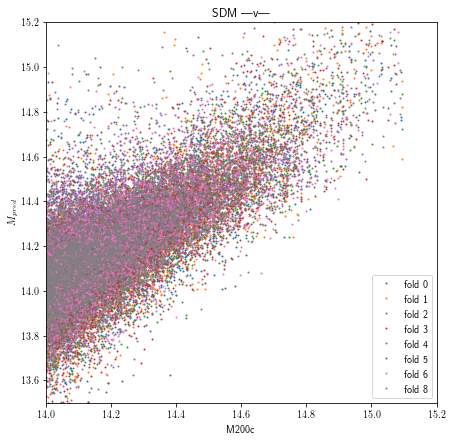

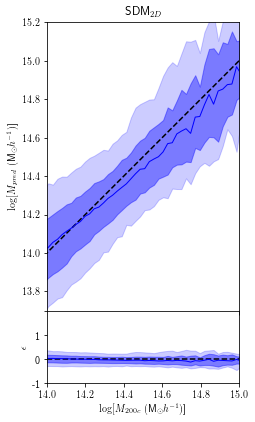

In [19]:
model_name = 'halo_sdm2d'
model_num = 10

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
sdm_par = sdm_dat['params']
# sdm_dat['fold'] = np.array([[i]*int(len(sdm_dat['logmass_pred'])/10) for i in range(10)]).flatten()
# sdm_dat['fold'] = np.array(list(sdm_dat['fold']) + [9]*(len(sdm_dat['logmass_pred']) - len(sdm_dat['fold'])))

# sdm_dat = np.load('/home/mho1/scratch/halo_cnn/mich/sdm_mich_preds.npy')
# sdm_dat = sdm_dat.reshape(1)[0]

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

plt.figure(figsize=(7,7))
for i in range(int(max(sdm_dat['fold']))):
    print('fold',i)
    if i!=7:
        plt.plot(sdm_dat['logmass_test'][sdm_dat['fold']==i], 
                 sdm_dat['logmass_pred'][sdm_dat['fold']==i],
                 '.', markersize=2, label='fold '+str(i))
plt.xlim(14,15.2)
plt.ylim(13.5,15.2)

plt.xlabel('M200c')
plt.ylabel('$M_{pred}$')
plt.title('SDM |v|')
plt.legend()

sdm_dat['logmass_test'] = sdm_dat['logmass_test'][sdm_dat['fold']!=7]
sdm_dat['logmass_pred'] = sdm_dat['logmass_pred'][sdm_dat['fold']!=7]

s=1

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

# ax1.plot(cnn_dat['logmass_test'][cnn_dat['logmass_test']>15.05],
#          cnn_dat['logmass_pred'][cnn_dat['logmass_test']>15.05],'.', c='r'
#         )
matt.binnedplot(sdm_dat['logmass_test'], sdm_dat['logmass_pred'], n=50, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='b'
            )


ax1.set_ylabel(r'$\log[M_{pred}\ ($M$_\odot h^{-1})$]',fontsize=10)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**sdm_dat['logmass_pred'])/(10.**sdm_dat['logmass_test']) - 1.

pred_err = sdm_dat['logmass_pred'] - sdm_dat['logmass_test']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(sdm_dat['logmass_test'],pred_err,n=50, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='b', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-1,ymax=2)
ax2.set_ylabel(r'$\epsilon$',fontsize=10)
ax2.set_xlabel(r'$\log[M_{200c}\ ($M$_\odot h^{-1})$]',fontsize=10)

ax2.set_yticklabels([-1,0,1])


ax1.set_title('SDM$_{2D}$')

plt.tight_layout()

# f.savefig(os.path.join(imdir,'pred_2d.pdf'),bbox_inches='tight')

## All

In [184]:
print('\n~~~~~ LOADING SDM DATA ~~~~~~')

model_name = 'halo_sdm1d'
model_num = 20

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
# sdm_err_1d = (10.**sdm_dat_1d['logmass_pred'])/(10.**sdm_dat_1d['logmass_test']) - 1.
sdm_err_1d = sdm_dat_1d['logmass_pred'] - sdm_dat_1d['logmass_test']


model_name = 'halo_sdm2d'
model_num = 10

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
sdm_dat_2d['fold'] = np.array([[i]*int(len(sdm_dat_2d['logmass_pred'])/10) for i in range(10)]).flatten()
sdm_dat_2d['fold'] = np.array(list(sdm_dat_2d['fold']) + [9]*(len(sdm_dat_2d['logmass_pred']) - len(sdm_dat_2d['fold'])))

sdm_dat_2d['logmass_pred'] = sdm_dat_2d['logmass_pred'][sdm_dat_2d['fold']!=7]
sdm_dat_2d['logmass_test'] = sdm_dat_2d['logmass_test'][sdm_dat_2d['fold']!=7]
sdm_dat_2d['fold'] = sdm_dat_2d['fold'][sdm_dat_2d['fold']!=7]

# sdm_err_2d = (10.**sdm_dat_2d['logmass_pred'])/(10.**sdm_dat_2d['logmass_test']) - 1.
sdm_err_2d = sdm_dat_2d['logmass_pred'] - sdm_dat_2d['logmass_test']



~~~~~ LOADING SDM DATA ~~~~~~


In [185]:
print('\n~~~~~ LOADING CNN DATA ~~~~~~')

model_name = 'halo_cnn1d_r'
model_num = 152

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat_1d['params']

# pred_err_1d = (10.**cnn_dat_1d['logmass_pred'])/(10.**cnn_dat_1d['logmass_test']) - 1.
pred_err_1d = cnn_dat_1d['logmass_pred'] - cnn_dat_1d['logmass_test']

model_name = 'halo_cnn2d_r'
# model_num = 67 # bwidth=0.25
model_num=57 # bwidth=0.15

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat_2d['params']

# pred_err_2d = (10.**cnn_dat_2d['logmass_pred'])/(10.**cnn_dat_2d['logmass_test']) - 1.
pred_err_2d = cnn_dat_2d['logmass_pred'] - cnn_dat_2d['logmass_test']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']



~~~~~ LOADING CNN DATA ~~~~~~


In [186]:
sdm_file = 'data_raw/MDPL2_0.25_MLv_0_preds.npy'

print('\n~~~~~ LOADING REGRESSION DATA ~~~~~~')
with open(os.path.join(data_dir, model_name_save, model_name_save + '_regr.p'),'rb') as f:
    regr_data = pickle.load(f)
pure_regr_pred = regr_data['pure']['pred']
contam_regr_pred = regr_data['contam']['pred']

print('\n~~~~~ CALCULATING MASS ERROR ~~~~~')
# pure_regr_err = 10.**( pure_regr_pred['logmass_pred'][pure_regr_pred['in_test']] - pure_regr_pred['logmass'][pure_regr_pred['in_test']] )  - 1.
# contam_regr_err = 10.**( contam_regr_pred['logmass_pred'][contam_regr_pred['in_test']] - contam_regr_pred['logmass'][contam_regr_pred['in_test']] )  - 1.
pure_regr_err = pure_regr_pred['logmass_pred'][pure_regr_pred['in_test']] - pure_regr_pred['logmass'][pure_regr_pred['in_test']]
contam_regr_err = contam_regr_pred['logmass_pred'][contam_regr_pred['in_test']] - contam_regr_pred['logmass'][contam_regr_pred['in_test']]


~~~~~ LOADING REGRESSION DATA ~~~~~~

~~~~~ CALCULATING MASS ERROR ~~~~~


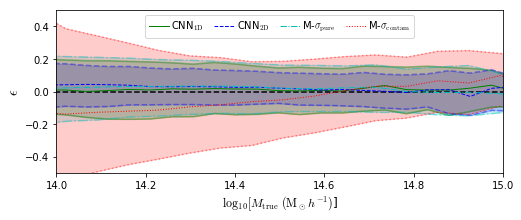

In [15]:
f, ax = plt.subplots(figsize=(8,3))

ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)

matt.binnedplot(pure_regr_pred['logmass'][pure_regr_pred['in_test']],
                pure_regr_err,
                n=25, percentiles=[34], median=True, ax=ax, 
                label='M-$\sigma_\mathrm{pure}$',c='c', errorbar=False, names=False, 
                log=0, linestyle='-.', err_lines=True, lw=1., alpha=0.2)
           
matt.binnedplot(contam_regr_pred['logmass'][contam_regr_pred['in_test']],
                contam_regr_err,
                n=25, percentiles=[34], median=True, ax=ax, 
                label='M-$\sigma_\mathrm{contam}$',c='r', errorbar=False, names=False, 
                log=0, linestyle=':', err_lines=True, lw=1., alpha=0.2)


ax.set_xlim(xmin=14, xmax=15)

ax.set_ylim(ymin=-0.5,ymax=0.5)
ax.set_ylabel(r'$\epsilon$',fontsize=14)
ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

plt.legend(ncol=4, loc=9, fontsize=10, 
           handletextpad=0.25, columnspacing=1#, handlelength=1.3
          )

f.savefig(os.path.join(imdir,'err_all_1.pdf'),bbox_inches='tight', dpi=500)

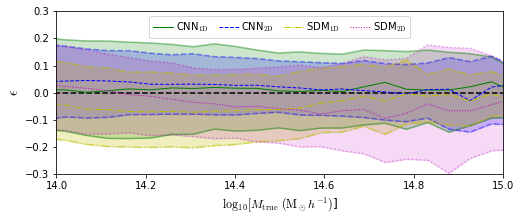

In [31]:
f, ax = plt.subplots(figsize=(8,3))

ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)


matt.binnedplot(sdm_dat_1d['logmass_test'],sdm_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'SDM$_\mathrm{1D}$',c='y', errorbar=False, 
                names=False, log=0, linestyle='-.', err_lines=True,lw=1., alpha=0.25)
matt.binnedplot(sdm_dat_2d['logmass_test'],sdm_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax, label=r'SDM$_\mathrm{2D}$',c='m', errorbar=False, 
                names=False, log=0, linestyle=':', err_lines=True, lw=1., alpha=0.15)




ax.set_xlim(xmin=14, xmax=15)

ax.set_ylim(ymin=-0.3,ymax=0.3)
ax.set_ylabel(r'$\epsilon$',fontsize=14)
ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

plt.legend(ncol=4, loc=9, fontsize=10, 
           handletextpad=0.25, columnspacing=1#, handlelength=1.3
          )

f.savefig(os.path.join(imdir,'err_all_2.pdf'),bbox_inches='tight', dpi=500) 

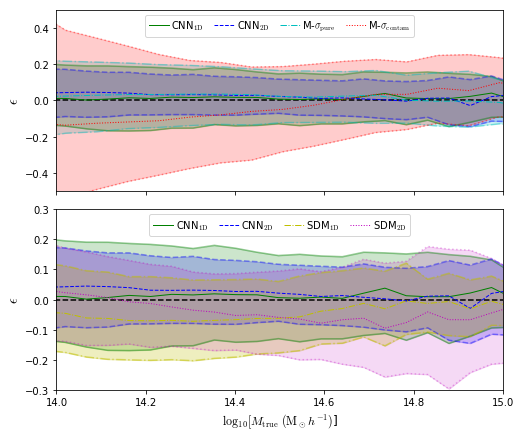

In [32]:
f = plt.figure(figsize=[8,7])
gs = mpl.gridspec.GridSpec(2,1,hspace=0.1)

#~~~ Upper
ax1 = f.add_subplot(gs[0,0])

ax1.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax1, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax1, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)

matt.binnedplot(pure_regr_pred['logmass'][pure_regr_pred['in_test']],
                pure_regr_err,
                n=25, percentiles=[34], median=True, ax=ax1, 
                label='M-$\sigma_\mathrm{pure}$',c='c', errorbar=False, names=False, 
                log=0, linestyle='-.', err_lines=True, lw=1., alpha=0.2)
           
matt.binnedplot(contam_regr_pred['logmass'][contam_regr_pred['in_test']],
                contam_regr_err,
                n=25, percentiles=[34], median=True, ax=ax1, 
                label='M-$\sigma_\mathrm{contam}$',c='r', errorbar=False, names=False, 
                log=0, linestyle=':', err_lines=True, lw=1., alpha=0.2)


ax1.set_xlim(xmin=14, xmax=15)

ax1.set_ylim(ymin=-0.5,ymax=0.5)
ax1.set_ylabel(r'$\epsilon$',fontsize=14)
# ax1.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

plt.legend(ncol=4, loc=9, fontsize=10, 
           handletextpad=0.25, columnspacing=1#, handlelength=1.3
          )


#~~~ Upper

ax2 = f.add_subplot(gs[1,0])

ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax2, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax2, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)


matt.binnedplot(sdm_dat_1d['logmass_test'],sdm_err_1d,n=25, percentiles=[34], 
                median=True, ax=ax2, label=r'SDM$_\mathrm{1D}$',c='y', errorbar=False, 
                names=False, log=0, linestyle='-.', err_lines=True,lw=1., alpha=0.25)
matt.binnedplot(sdm_dat_2d['logmass_test'],sdm_err_2d,n=25, percentiles=[34], 
                median=True, ax=ax2, label=r'SDM$_\mathrm{2D}$',c='m', errorbar=False, 
                names=False, log=0, linestyle=':', err_lines=True, lw=1., alpha=0.15)




ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.3,ymax=0.3)
ax2.set_ylabel(r'$\epsilon$',fontsize=14)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax2.legend(ncol=4, loc=9, fontsize=10, 
           handletextpad=0.25, columnspacing=1#, handlelength=1.3
          )

f.savefig(os.path.join(imdir,'err_all.pdf'),bbox_inches='tight', dpi=500) 

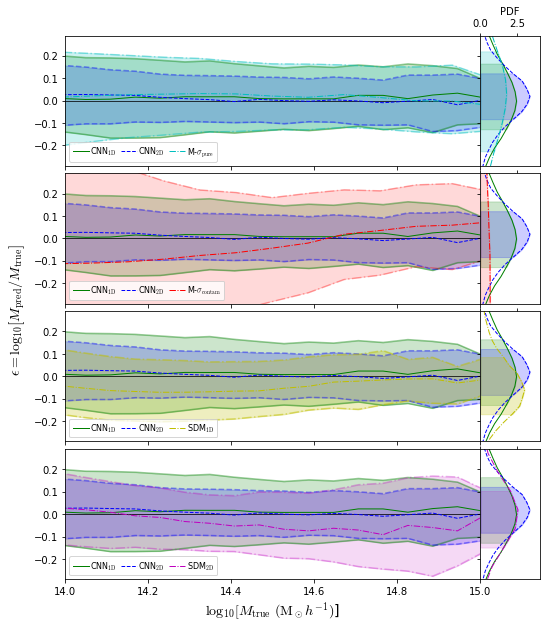

In [187]:
f = plt.figure(figsize=[8.5,10])
gs = mpl.gridspec.GridSpec(4,2,hspace=0.06, wspace=0.0, width_ratios=[7,1])

def compare_pdf(ax, logmass, err, name, c, linestyle='-', alpha=0.2):
    h_val, h_bin = np.histogram(err, bins=50, density=True)
    
    h_bin = np.array([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)])
    ax.plot( h_val, h_bin,
                label=name, c=c, lw=1, linestyle=linestyle)
    
    pc = np.percentile(err, [16,84])
    
    plt.fill_betweenx(h_bin[(h_bin>=pc[0])&(h_bin<=pc[1])],0,h_val[(h_bin>=pc[0])&(h_bin<=pc[1])],
                      color=c, alpha=alpha
                     )

def comparison_plot(y, logmass, err, name, c, linestyle='-.', alpha=0.2, null_x=True):
    ax = f.add_subplot(gs[y,0])
    
    ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='-', lw=0.75)

    matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=20, percentiles=[34], 
                    median=True, ax=ax, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                    names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
    matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=20, percentiles=[34], 
                    median=True, ax=ax, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                    names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)
    
    matt.binnedplot(logmass,
                    err,
                    n=20, percentiles=[34], median=True, ax=ax, 
                    label=name,c=c, errorbar=False, names=False, 
                    log=0, linestyle=linestyle, err_lines=True, lw=1., alpha=alpha)
    
    ax.set_xlim(xmin=14,xmax=15)
    
    ax.set_ylim(ymin=-0.29,ymax=0.29)
#     ax1.set_ylabel(r'$\epsilon$',fontsize=14)
    # ax1.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)
    if null_x: ax.xaxis.set_major_formatter(plt.NullFormatter())
    else: ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=14)

    plt.legend(ncol=3, loc=3, fontsize=8, 
               handletextpad=0.2, columnspacing=0.5#, handlelength=1.3
              )
    
    ax_1 = f.add_subplot(gs[y,1])
    
    compare_pdf(ax_1,cnn_dat_1d['logmass_test'],pred_err_1d,r'CNN$_\mathrm{1D}$',
                c='g', linestyle='-', alpha=0.2)
    compare_pdf(ax_1,cnn_dat_2d['logmass_test'],pred_err_2d,r'CNN$_\mathrm{1D}$',
                c='b', linestyle='--', alpha=0.2)
    compare_pdf(ax_1, logmass,err,name,c, linestyle='-.', alpha=alpha)
    
    ax_1.set_ylim(-0.29,0.29)
    ax_1.set_xlim(0,4)
    ax_1.xaxis.tick_top()
    
    ax_1.yaxis.set_major_formatter(plt.NullFormatter())
    if y>0: ax_1.xaxis.set_major_formatter(plt.NullFormatter())
    else: 
        ax_1.xaxis.set_label_position('top') 
        ax_1.set_xlabel('PDF')
    return ax

ax1 = comparison_plot(0,pure_regr_pred['logmass'][pure_regr_pred['in_test']], pure_regr_err, 
                      name='M-$\sigma_\mathrm{pure}$', c='c', alpha=0.2, linestyle='-.'
                     )
ax2 = comparison_plot(1,contam_regr_pred['logmass'][contam_regr_pred['in_test']], contam_regr_err,
                      name='M-$\sigma_\mathrm{contam}$', c='r', alpha=0.15
                     )
ax3 = comparison_plot(2,sdm_dat_1d['logmass_test'],sdm_err_1d,
                      name=r'SDM$_\mathrm{1D}$', c='y', alpha=0.25
                     )
ax4 = comparison_plot(3,sdm_dat_2d['logmass_test'],sdm_err_2d,
                      name=r'SDM$_\mathrm{2D}$', c='m', alpha=0.15, null_x=False
                     )

f.text(0.03, 0.5, r'$\epsilon = \log_{10}\left[M_\mathrm{pred}/M_\mathrm{true}\right]$', 
       va='center', rotation='vertical',fontsize=14)

f.savefig(os.path.join(imdir,'err_all.pdf'),bbox_inches='tight', dpi=500) 

In [39]:
logm_min = 14
logm_max = 15

def err_perc(logmass, err, name):
    a,b,c = np.percentile(err[(logmass>logm_min) & (logmass<logm_max)], q=[16,50,84])
    d = np.mean(err[(logmass>logm_min) & (logmass<logm_max)])
    e = np.std(err[(logmass>logm_min) & (logmass<logm_max)])
    
    print(' ~~ ' +name + ' ~~ ' )
    print('ebar:', str(d)[0:8])
    print('e+De:', str(b)[0:8] + ' : +' + str(c-b)[0:8] + ' : -' + str(b-a)[0:8])
    print('De:', str(c-a)[0:8])
    print('sige:', str(e)[0:8])
    
    print('')
    return 

err_perc(pure_regr_pred['logmass'][pure_regr_pred['in_test']], pure_regr_err, 'Msig_pure')
err_perc(contam_regr_pred['logmass'][contam_regr_pred['in_test']], contam_regr_err, 'Msig_contam')
err_perc(sdm_dat_1d['logmass_test'],sdm_err_1d, 'SDM1D')
err_perc(sdm_dat_2d['logmass_test'],sdm_err_2d, 'SDM2D')
err_perc(cnn_dat_1d['logmass_test'],pred_err_1d, 'CNN1D')
err_perc(cnn_dat_2d['logmass_test'],pred_err_2d, 'CNN2D')

 ~~ Msig_pure ~~ 
ebar: 0.016900
e+De: 0.024508 : +0.169257 : -0.184435
De: 0.353692
sige: 0.182561

 ~~ Msig_contam ~~ 
ebar: -0.05907
e+De: -0.08033 : +0.361305 : -0.323060
De: 0.684366
sige: 0.369081

 ~~ SDM1D ~~ 
ebar: -0.04821
e+De: -0.05998 : +0.145550 : -0.127860
De: 0.273411
sige: 0.150620

 ~~ SDM2D ~~ 
ebar: -0.01184
e+De: -0.01386 : +0.147776 : -0.148171
De: 0.295947
sige: 0.160363

 ~~ CNN1D ~~ 
ebar: 0.016928
e+De: 0.011107 : +0.168900 : -0.163319
De: 0.332219
sige: 0.171825

 ~~ CNN2D ~~ 
ebar: 0.015822
e+De: 0.015981 : +0.113960 : -0.115516
De: 0.229477
sige: 0.125201



## Log-normality

### old

skew: 0.47033689744936164
kurtosis: 0.7719108808854798
skew: 1.372300870893455
kurtosis: 5.0377026503200675
skew: 0.47033688549755426
kurtosis: 0.771910977035374


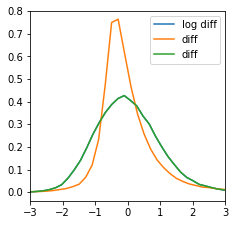

In [32]:
f = plt.figure(figsize=(3.5,3.5))

res = cnn_dat_1d['logmass_pred']-cnn_dat_1d['logmass_test']
res -= np.mean(res)
res /= np.std(res)
res = res[np.abs(res)<5]
print('skew:',scipy.stats.skew(res))
print('kurtosis:',scipy.stats.kurtosis(res))

h_val, h_bin = np.histogram(res, bins=50, density=True)
plt.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label='log diff')


res = 10**cnn_dat_1d['logmass_pred']-10**cnn_dat_1d['logmass_test']
res -= np.mean(res)
res /= np.std(res)
res = res[np.abs(res)<5]
print('skew:',scipy.stats.skew(res))
print('kurtosis:',scipy.stats.kurtosis(res))

h_val, h_bin = np.histogram(res, bins=50, density=True)
plt.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label='diff')

res = np.log(10**cnn_dat_1d['logmass_pred'])-np.log(10**cnn_dat_1d['logmass_test'])
res -= np.mean(res)
res /= np.std(res)
res = res[np.abs(res)<5]
print('skew:',scipy.stats.skew(res))
print('kurtosis:',scipy.stats.kurtosis(res))

h_val, h_bin = np.histogram(res, bins=50, density=True)
plt.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label='diff')

plt.xlim(-3,3)

plt.legend()

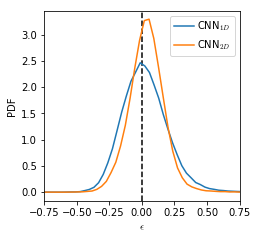

In [11]:
f = plt.figure(figsize=(3.5,3.5))
ax = plt.subplot()

def plot_pdf(pred_err,ax,name):
    h_val, h_bin = np.histogram(pred_err[np.abs(pred_err)<1], bins=50, density=True)
    ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label=name)

ax.axvline(0,c='k',linestyle='--')    

plot_pdf(pred_err_1d,ax,'CNN$_{1D}$')
plot_pdf(pred_err_2d,ax,'CNN$_{2D}$')

plt.ylabel('PDF')
plt.xlabel('$\epsilon$')
plt.xlim(-0.75,0.75)


plt.legend(loc=1, fontsize=10, handletextpad=0.25)

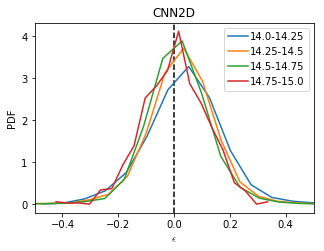

In [12]:
f = plt.figure(figsize=(5,3.5))
ax = plt.subplot()

def plot_pdf(pred_err,ax,name):
    h_val, h_bin = np.histogram(pred_err[np.abs(pred_err)<1], bins=20, density=True)
    ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label=name)

ax.axvline(0,c='k',linestyle='--')    

n = 4
bins = np.linspace(14,15,n+1)
for i in range(n):
    plot_pdf(pred_err_2d[(cnn_dat_2d['logmass_test']>bins[i]) & (cnn_dat_2d['logmass_test']<bins[i+1])],
             ax,str(bins[i])[:5]+'-'+str(bins[i+1])[:5])

plt.ylabel('PDF')
plt.xlabel('$\epsilon$')
plt.title('CNN2D')
plt.xlim(-0.5,0.5)


plt.legend(loc=1, fontsize=10, handletextpad=0.25)

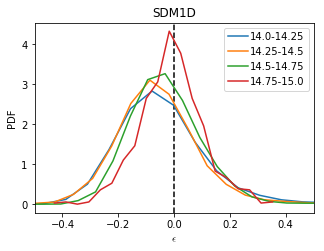

In [13]:
f = plt.figure(figsize=(5,3.5))
ax = plt.subplot()

def plot_pdf(pred_err,ax,name):
    h_val, h_bin = np.histogram(pred_err[np.abs(pred_err)<1], bins=20, density=True)
    ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, label=name)

ax.axvline(0,c='k',linestyle='--')    

n = 4
bins = np.linspace(14,15,n+1)
for i in range(n):
    plot_pdf(sdm_err_1d[(sdm_dat_1d['logmass_test']>bins[i]) & (sdm_dat_1d['logmass_test']<bins[i+1])],
             ax,str(bins[i])[:5]+'-'+str(bins[i+1])[:5])

plt.ylabel('PDF')
plt.xlabel('$\epsilon$')
plt.title('SDM1D')
plt.xlim(-0.5,0.5)


plt.legend(loc=1, fontsize=10, handletextpad=0.25)

### for paper

In [41]:
def plot_pdf(logmass, pred_err,ax,name, norm=True, c='b', linestyle='-', dashes=None):
    err = pred_err[(logmass>14)&(logmass<15)]
    sig = np.std(err)
    err = (err-np.mean(err))/sig
    h_val, h_bin = np.histogram(err, bins=50, density=True)
    
    sig_str = str(round(sig,3))
    name += '; $\sigma_\epsilon=$'+ sig_str+'0'*(5-len(sig_str))
    if dashes is None:
        ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, 
                label=name, c=c, lw=1.5,linestyle=linestyle)
    else:
        ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, 
                label=name, c=c, lw=1.5,linestyle=linestyle,dashes=dashes)


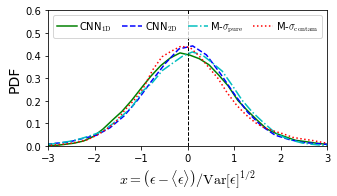

In [12]:
f = plt.figure(figsize=(5,2.5))
ax = plt.subplot()

ax.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(pure_regr_pred['logmass'][pure_regr_pred['in_test']], pure_regr_err,ax,'M-$\sigma_\mathrm{pure}$',
         c='c',linestyle='-.')
plot_pdf(contam_regr_pred['logmass'][contam_regr_pred['in_test']], contam_regr_err,ax,'M-$\sigma_\mathrm{contam}$',
         c='r',linestyle=':')


plt.ylabel('PDF', fontsize=14)
plt.xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\mathrm{Var}[\epsilon]^{1/2}$', fontsize=14)
plt.xlim(-3,3)
plt.ylim(0,0.6)


plt.legend(loc=9, ncol=4, fontsize=10, handletextpad=0.25, columnspacing=1)

f.savefig(os.path.join(imdir,'lognorm_1.pdf'),bbox_inches='tight', dpi=500) 

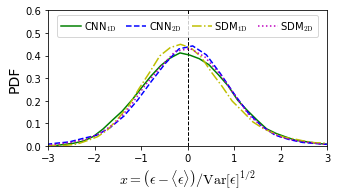

In [13]:
f = plt.figure(figsize=(5,2.5))
ax = plt.subplot()

ax.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(sdm_dat_1d['logmass_test'],sdm_err_1d,ax,'SDM$_\mathrm{1D}$',
         c='y',linestyle='-.')
plot_pdf(sdm_dat_2d['logmass_test'],sdm_err_2d,ax,'SDM$_\mathrm{2D}$',
         c='m',linestyle=':')

plt.ylabel('PDF', fontsize=14)
plt.xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\mathrm{Var}[\epsilon]^{1/2}$', fontsize=14)
plt.xlim(-3,3)
plt.ylim(0,0.6)


plt.legend(loc=9, ncol=4, fontsize=10, handletextpad=0.25, columnspacing=1)

f.savefig(os.path.join(imdir,'lognorm_2.pdf'),bbox_inches='tight', dpi=500) 

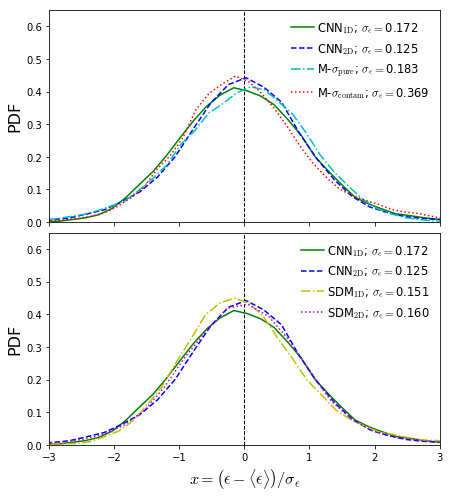

In [42]:
f = plt.figure(figsize=[7,8])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[1,1], hspace=0.05)

#~~~~ Upper
ax1 = f.add_subplot(gs[0,0])
ax1.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax1,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax1,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(pure_regr_pred['logmass'][pure_regr_pred['in_test']], pure_regr_err,ax1,'M-$\sigma_\mathrm{pure}$',
         c='c',linestyle='-.')
plot_pdf(contam_regr_pred['logmass'][contam_regr_pred['in_test']], contam_regr_err,ax1,'M-$\sigma_\mathrm{contam}$',
         c='r',linestyle=':')


ax1.set_ylabel('PDF', fontsize=16)
# ax1.set_xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\mathrm{Var}[\epsilon]^{1/2}$', fontsize=14)
ax1.set_xlim(-3,3)
ax1.set_ylim(0,0.65)

ax1.xaxis.set_major_formatter(plt.NullFormatter())

plt.legend(loc=0, ncol=1, fontsize=11.5, handletextpad=0.25, columnspacing=1, frameon=False)


#~~~~ Lower
ax2 = f.add_subplot(gs[1,0])
ax2.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax2,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax2,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(sdm_dat_1d['logmass_test'],sdm_err_1d,ax2,'SDM$_\mathrm{1D}$',
         c='y',linestyle='-.')
plot_pdf(sdm_dat_2d['logmass_test'],sdm_err_2d,ax2,'SDM$_\mathrm{2D}$',
         c='m',linestyle=':')

plt.legend(loc=0, ncol=1, fontsize=11.5, handletextpad=0.25, columnspacing=1, frameon=False)

ax2.set_ylabel('PDF', fontsize=16)
ax2.set_xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\sigma_\epsilon$', fontsize=16)
ax2.set_xlim(-3,3)
ax2.set_ylim(0,0.65)

f.savefig(os.path.join(imdir,'lognorm.pdf'),bbox_inches='tight', dpi=500) 

In [43]:
alpha=2

def print_stats(logmass, pred_err,name):
    err = pred_err[(logmass>14)&(logmass<15)]
    sigma = np.std(err)
    err = (err-np.mean(err))/sigma
    
    gamma = scipy.stats.skew(err)
    kappa = scipy.stats.kurtosis(err)
    
    sigma_ln = sigma*np.log(10)
    
    gam_uncer = alpha**3*sigma_ln**3/6.*gamma
    kap_uncer = alpha**4*sigma_ln**4/24.*kappa
    
    print('\n~~~',name,'~~~')
    print('Sigma:',str(sigma)[0:7])
    print('Sigma_ln:',str(sigma_ln)[0:7])
    print('Skew:', str(gamma)[0:7])
    print('Kurtosis:', str(kappa)[0:7])
    print('Gamma Uncertainty:', str(gam_uncer)[0:7])
    print('Kappa Uncertainty:', str(kap_uncer)[0:7])
    print('Total Uncertainty:', str(gam_uncer+kap_uncer)[0:7])


In [44]:
print_stats(cnn_dat_1d['logmass_test'],pred_err_1d,'CNN_1d')
print_stats(cnn_dat_2d['logmass_test'], pred_err_2d,'CNN_2d')
print_stats(pure_regr_pred['logmass'][pure_regr_pred['in_test']], pure_regr_err,'Msig_pure')
print_stats(contam_regr_pred['logmass'][contam_regr_pred['in_test']], contam_regr_err,'Msig_contam')
print_stats(sdm_dat_1d['logmass_test'],sdm_err_1d,'SDM_1d')
print_stats(sdm_dat_2d['logmass_test'],sdm_err_2d,'SDM_2d')


~~~ CNN_1d ~~~
Sigma: 0.17182
Sigma_ln: 0.39564
Skew: 0.35836
Kurtosis: 0.77590
Gamma Uncertainty: 0.02959
Kappa Uncertainty: 0.01267
Total Uncertainty: 0.04226

~~~ CNN_2d ~~~
Sigma: 0.12520
Sigma_ln: 0.28828
Skew: 0.16351
Kurtosis: 1.61177
Gamma Uncertainty: 0.00522
Kappa Uncertainty: 0.00742
Total Uncertainty: 0.01264

~~~ Msig_pure ~~~
Sigma: 0.18256
Sigma_ln: 0.42036
Skew: -0.2589
Kurtosis: 0.42254
Gamma Uncertainty: -0.0256
Kappa Uncertainty: 0.00879
Total Uncertainty: -0.0168

~~~ Msig_contam ~~~
Sigma: 0.36908
Sigma_ln: 0.84984
Skew: 0.36934
Kurtosis: 0.62913
Gamma Uncertainty: 0.30226
Kappa Uncertainty: 0.21877
Total Uncertainty: 0.52104

~~~ SDM_1d ~~~
Sigma: 0.15062
Sigma_ln: 0.34681
Skew: 0.79685
Kurtosis: 2.19445
Gamma Uncertainty: 0.04432
Kappa Uncertainty: 0.02116
Total Uncertainty: 0.06548

~~~ SDM_2d ~~~
Sigma: 0.16036
Sigma_ln: 0.36925
Skew: 0.33656
Kurtosis: 2.12880
Gamma Uncertainty: 0.02259
Kappa Uncertainty: 0.02638
Total Uncertainty: 0.04897


# Richness

In [155]:

par = OrderedDict([ 
    
    ('err_type'     ,   'pred'), #pred
    
    ('M_bins'       ,   4),
    ('N_bins'       ,   4)
])


model_name = 'halo_cnn1d_r'
model_num = 149

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

data_rich_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '_rich.npy'), 
                encoding='latin1')
data_rich_1d['err_keras'] = data_rich_1d['logmass_keras'] - data_rich_1d['logmass_keras1.0']
data_rich_1d['err_sigv'] = data_rich_1d['logmass_sigv'] - data_rich_1d['logmass_sigv1.0']


model_name = 'halo_cnn2d_r'
model_num = 57

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

data_rich_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '_rich.npy'), 
                encoding='latin1')
data_rich_2d['err_keras'] = data_rich_2d['logmass_keras'] - data_rich_2d['logmass_keras1.0']
data_rich_2d['err_sigv'] = data_rich_2d['logmass_sigv'] - data_rich_2d['logmass_sigv1.0']

In [156]:
model_name = 'halo_sdm1d_rich'
model_num = 11
print(model_name)

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()

err_sdm1d = np.zeros(len(sdm_dat_1d['x']))

for i in range(len(err_sdm1d)):
    j = np.argwhere((sdm_dat_1d['logmass_test'] == sdm_dat_1d['logmass_test'][i] )&
                    (sdm_dat_1d['x']==1)).flatten()[0]
    
#     err_sdm1d[i] = ((10.**sdm_dat_1d['logmass_pred'][i])/(10.**sdm_dat_1d['logmass_pred'][j]))**(1)-1.
    err_sdm1d[i] = sdm_dat_1d['logmass_pred'][i]-sdm_dat_1d['logmass_pred'][j]


model_name = 'halo_sdm1d_rich'
model_num = 12
print(model_name)

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_1d_b = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()

err_sdm1d_b = np.zeros(len(sdm_dat_1d_b['x']))

for i in range(len(err_sdm1d_b)):
    j = np.argwhere((sdm_dat_1d_b['logmass_test'] == sdm_dat_1d_b['logmass_test'][i] )&
                    (sdm_dat_1d_b['x']==1)).flatten()[0]
    
#     err_sdm1d_b[i] = ((10.**sdm_dat_1d_b['logmass_pred'][i])/(10.**sdm_dat_1d_b['logmass_pred'][j]))**(1)-1.
    err_sdm1d_b[i] = sdm_dat_1d_b['logmass_pred'][i]-sdm_dat_1d_b['logmass_pred'][j]

err_sdm1d = err_sdm1d[sdm_dat_1d['x']>0.5]
x_sdm1d = sdm_dat_1d['x'][sdm_dat_1d['x']>0.5]

err_sdm1d = np.append(err_sdm1d, err_sdm1d_b[sdm_dat_1d_b['x']<0.5] )
x_sdm1d = np.append(x_sdm1d, sdm_dat_1d_b['x'][sdm_dat_1d_b['x']<0.5] )



# ~~~~~~~~~~~
model_name = 'halo_sdm2d_rich'
model_num = 5
print(model_name)

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()

err_sdm2d = np.zeros(len(sdm_dat_2d['x']))

for i in range(len(err_sdm2d)):
    j = np.argwhere((sdm_dat_2d['logmass_test'] == sdm_dat_2d['logmass_test'][i] )&
                    (sdm_dat_2d['x']==1)).flatten()[0]
    
#     err_sdm2d[i] = ((10.**sdm_dat_2d['logmass_pred'][i])/(10.**sdm_dat_2d['logmass_pred'][j]))**(1)-1.
    err_sdm2d[i] = sdm_dat_2d['logmass_pred'][i]-sdm_dat_2d['logmass_pred'][j]


halo_sdm1d_rich
halo_sdm1d_rich
halo_sdm2d_rich


In [159]:
ind = np.random.choice(range(len(contam_cat)), 
                           int(0.05*len(contam_cat)),
                           replace=False
                          )
cat = contam_cat[ind]

n=100
out = np.zeros((len(cat)*n,3),'f')

a=0
for x in np.linspace(0,1,n):
    if a%5: print(x)
    out[a*len(cat):(a+1)*len(cat),0] = np.log10(cat.prop['M200c'])
    for j in range(len(cat)):
        s = int(x*len(cat.gal[j]))/len(cat.gal[j])
        out[a*len(cat)+j,1] = (np.log10(np.std(np.random.choice(cat.gal[j]['vlos'], 
                                                       int(s*len(cat.gal[j])), replace=False))) - \
                               regr['pure']['model']['intercept'] )/regr['pure']['model']['coef'] + \
                                np.log10(rel_mass)
        out[a*len(cat)+j,2] = s
    a+=1
    
sigv_pure_rich = out

err = np.zeros(len(out))

for i in range(len(err)):
    j = len(err) - len(cat) + i%len(cat)
    
    if out[i,0]!=out[j,0]: raise
    if out[j,2]!=1: raise
    
#     err[i] = ((10.**out[i,1])/(10.**out[j,1]))**(1)-1.
    err[i] = out[i,1]-out[j,1]

out_sigvpure = out
err_sigvpure = err

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.010101010101010102


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


0.020202020202020204
0.030303030303030304
0.04040404040404041
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.21212121212121213
0.22222222222222224
0.23232323232323235
0.24242424242424243
0.26262626262626265
0.27272727272727276
0.2828282828282829
0.29292929292929293
0.31313131313131315
0.32323232323232326
0.33333333333333337
0.3434343434343435
0.36363636363636365
0.37373737373737376
0.38383838383838387
0.393939393939394
0.4141414141414142
0.42424242424242425
0.43434343434343436
0.4444444444444445
0.4646464646464647
0.4747474747474748
0.48484848484848486
0.494949494949495
0.5151515151515152
0.5252525252525253
0.5353535353535354
0.5454545454545455
0.5656565656565657
0.5757575757575758
0.5858585858585859
0.595959595959596
0.6161616161616162
0.6262626262626263
0.6363636363636365
0.6464646464646465
0


~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE ~~~~~~


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


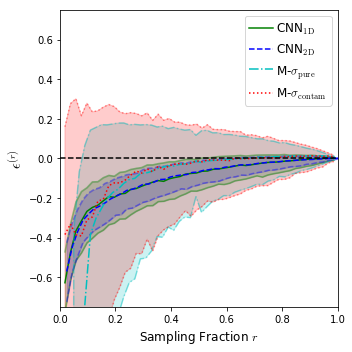

In [72]:
print('\n~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE ~~~~~~')


f,ax = plt.subplots(figsize=(5,5))


matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_keras'][data_rich_1d['gen']==1],
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='g', label='CNN$_\mathrm{1D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-', repl_nan=-10**10
               )
matt.binnedplot(data_rich_2d['rich_frac'][data_rich_2d['gen']==1], data_rich_2d['err_keras'][data_rich_2d['gen']==1],
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='b', label='CNN$_\mathrm{2D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='--', repl_nan=-10**10
               )
n = matt.binnedplot(out_sigvpure[:,2], err_sigvpure,
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='c', label='M-$\sigma_\mathrm{pure}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-.', repl_nan=-10**10
               )
matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_sigv'][data_rich_1d['gen']==1],
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='r', label='M-$\sigma_\mathrm{contam}$', 
                names=False, alpha=0.2, err_lines=True, linestyle=':', repl_nan=-10**10
               )





ax.axhline(y = 0, linestyle='dashed', c = 'k')
ax.set_xlim(0,1)
ax.set_ylim(-0.75, 0.75)
ax.set_xlabel('Sampling Fraction $r$', fontsize=12)

if par['err_type']=='true':
    ax.set_ylabel('$\epsilon$', fontsize=14)
elif par['err_type'] == 'pred':
    ax.set_ylabel('$\epsilon^{(r)}$', fontsize=14)

l = plt.legend(ncol=1, loc=1, fontsize=12,
               handletextpad=0.25, columnspacing=0.75#, handlelength=1.3
              )

plt.tight_layout()

f.savefig(os.path.join(imdir,'richmargin_1.pdf'),bbox_inches='tight', dpi=300)



~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE ~~~~~~


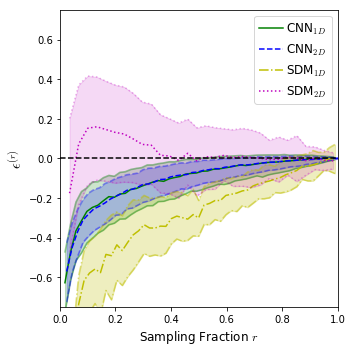

In [70]:
print('\n~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE ~~~~~~')


f,ax = plt.subplots(figsize=(5,5))

n = matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_keras'][data_rich_1d['gen']==1],
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='g', label='CNN$_{1D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-', repl_nan=-10**10
               )
matt.binnedplot(data_rich_2d['rich_frac'][data_rich_2d['gen']==1], data_rich_2d['err_keras'][data_rich_2d['gen']==1],
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='b', label='CNN$_{2D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='--', repl_nan=-10**10
               )

matt.binnedplot(x_sdm1d, err_sdm1d,
                n=50, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='y', label='SDM$_{1D}$', 
                names=False,alpha=0.25, err_lines=True, linestyle='-.', repl_nan=-10**10
               )
matt.binnedplot(sdm_dat_2d['x'], err_sdm2d,
                n=30, percentiles = [34],lw=1.5,
                median = True, ax=ax, log=0, c='m', label='SDM$_{2D}$', 
                names=False,alpha=0.15, err_lines=True, linestyle=':', repl_nan=-10**10
               )



ax.axhline(y = 0, linestyle='dashed', c = 'k')
ax.set_xlim(0,1)
ax.set_ylim(-0.75, 0.75)
ax.set_xlabel('Sampling Fraction $r$', fontsize=12)

if par['err_type']=='true':
    ax.set_ylabel('$\epsilon$', fontsize=14)
elif par['err_type'] == 'pred':
    ax.set_ylabel('$\epsilon^{(r)}$', fontsize=14)

l = plt.legend(ncol=1, loc=1, fontsize=12,
               handletextpad=0.25, columnspacing=0.75#, handlelength=1.3
              )

plt.tight_layout()

f.savefig(os.path.join(imdir,'richmargin_2.pdf'),bbox_inches='tight', dpi=300)


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


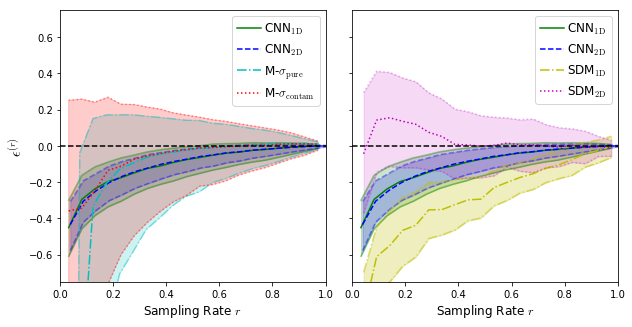

In [161]:
f = plt.figure(figsize=[10,5])
gs = mpl.gridspec.GridSpec(1,2,width_ratios=[1,1], wspace=0.1)

#~~~~ Left
ax1 = f.add_subplot(gs[0,0])

matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_keras'][data_rich_1d['gen']==1],
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax1, log=0, c='g', label='CNN$_\mathrm{1D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-', repl_nan=-10**10
               )
matt.binnedplot(data_rich_2d['rich_frac'][data_rich_2d['gen']==1], data_rich_2d['err_keras'][data_rich_2d['gen']==1],
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax1, log=0, c='b', label='CNN$_\mathrm{2D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='--', repl_nan=-10**10
               )
y = matt.binnedplot(out_sigvpure[:,2], err_sigvpure,
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax1, log=0, c='c', label='M-$\sigma_\mathrm{pure}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-.', repl_nan=-9
               )
matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_sigv'][data_rich_1d['gen']==1],
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax1, log=0, c='r', label='M-$\sigma_\mathrm{contam}$', 
                names=False, alpha=0.2, err_lines=True, linestyle=':', repl_nan=-10**10
               )

ax1.axhline(y = 0, linestyle='dashed', c = 'k')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.75, 0.75)
ax1.set_xlabel('Sampling Rate $r$', fontsize=12)

if par['err_type']=='true':
    ax1.set_ylabel('$\epsilon$', fontsize=14)
elif par['err_type'] == 'pred':
    ax1.set_ylabel('$\epsilon^{(r)}$', fontsize=14)

l = plt.legend(ncol=1, loc=1, fontsize=12,
               handletextpad=0.25, columnspacing=0.75#, handlelength=1.3
              )



#~~~~~ Right
ax2 = f.add_subplot(gs[0,1])

n = matt.binnedplot(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_keras'][data_rich_1d['gen']==1],
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax2, log=0, c='g', label='CNN$_\mathrm{1D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='-', repl_nan=-10**10
               )
matt.binnedplot(data_rich_2d['rich_frac'][data_rich_2d['gen']==1], data_rich_2d['err_keras'][data_rich_2d['gen']==1],
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax2, log=0, c='b', label='CNN$_\mathrm{2D}$', 
                names=False,alpha=0.2, err_lines=True, linestyle='--', repl_nan=-10**10
               )

matt.binnedplot(x_sdm1d, err_sdm1d,
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax2, log=0, c='y', label='SDM$_\mathrm{1D}$', 
                names=False,alpha=0.25, err_lines=True, linestyle='-.', repl_nan=-10**10
               )
matt.binnedplot(sdm_dat_2d['x'], err_sdm2d,
                n=20, percentiles = [34],lw=1.5,
                median = True, ax=ax2, log=0, c='m', label='SDM$_\mathrm{2D}$', 
                names=False,alpha=0.15, err_lines=True, linestyle=':', repl_nan=-10**10
               )


ax2.axhline(y = 0, linestyle='dashed', c = 'k')
ax2.set_xlim(0,1)
ax2.set_ylim(-0.75, 0.75)
ax2.set_xlabel('Sampling Rate $r$', fontsize=12)

ax2.yaxis.set_major_formatter(plt.NullFormatter())
# if par['err_type']=='true':
#     ax2.set_ylabel('$\epsilon$', fontsize=14)
# elif par['err_type'] == 'pred':
#     ax2.set_ylabel('$\epsilon^{(r)}$', fontsize=14)

l = plt.legend(ncol=1, loc=1, fontsize=12,
               handletextpad=0.25, columnspacing=0.75#, handlelength=1.3
              )


f.savefig(os.path.join(imdir,'richmargin.pdf'),bbox_inches='tight', dpi=300)


In [87]:
x_range = (0.6,0.8)

def e_68(x,err,name):
    a,b,c = np.percentile(err[(x>x_range[0]) & (x<x_range[1])], [16,50,84])
    
    print('\n~~'+ name)
    print('e68+-De68:',str(b)[0:8],':','-'+str(b-a)[0:8], ',', '+'+str(c-b)[0:8])
    print('De68:', str(c-a)[0:8])
    
e_68(out_sigvpure[:,2], err_sigvpure, 'sigv_pure')
e_68(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_sigv'][data_rich_1d['gen']==1], 'sigv_contam')
e_68(x_sdm1d, err_sdm1d,'sdm1d')
e_68(sdm_dat_2d['x'], err_sdm2d,'sdm2d')
e_68(data_rich_1d['rich_frac'][data_rich_1d['gen']==1], data_rich_1d['err_keras'][data_rich_1d['gen']==1],'cnn1d')
e_68(data_rich_2d['rich_frac'][data_rich_2d['gen']==1], data_rich_2d['err_keras'][data_rich_2d['gen']==1],'cnn2d')


~~sigv_pure
e68+-De68: 0.003353 : -0.141264 , +0.095736
De68: 0.237000

~~sigv_contam
e68+-De68: 0.000719 : -0.154352 , +0.114198
De68: 0.268550

~~sdm1d
e68+-De68: -0.14002 : -0.090352 , +0.083600
De68: 0.173953

~~sdm2d
e68+-De68: 0.000527 : -0.128280 , +0.126979
De68: 0.255259

~~cnn1d
e68+-De68: -0.02896 : -0.068317 , +0.044458
De68: 0.112775

~~cnn2d
e68+-De68: -0.02767 : -0.048517 , +0.033708
De68: 0.082226


### Mass, richness dependence


~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE AT BINNED MASSES ~~~~~~


NameError: name 'data_rich' is not defined

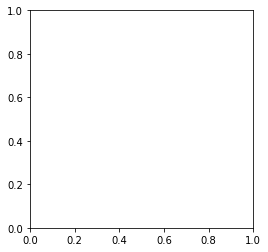

In [188]:

print('\n~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE AT BINNED MASSES ~~~~~~')

f,ax = plt.subplots(figsize=(4,4))

bins = np.linspace(data_rich['logmass'].min(), data_rich['logmass'].max(), par['M_bins'] + 1)
colr = ['b','r','g','c','m','y']

for i in range(par['M_bins']):
    data_bin = data_rich[(data_rich['logmass'] >= bins[i]) & (data_rich['logmass'] < bins[i+1]) &
                         (data_rich['mbin'])]
    print(len(data_bin))
    if len(data_bin)>0:
        matt.binnedplot(data_bin['rich_frac'], data_bin['err_keras'],
                        n=20, percentiles = [34],
                        median = True, ax=ax, log=0, c= colr[i%len(colr)], names=False,
                        label='[' + str(bins[i])[0:5] + ', ' + str(bins[i+1])[0:5] + ']'
                       )

ax.axhline(y = 0, linestyle='dashed', c = 'k')
ax.set_xlim(0,1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Richness Fraction', fontsize=12)

ax.set_ylabel('$\epsilon_{1.0}$', fontsize=12)

plt.legend(fontsize=9, ncol=2, title='$\log[M_{200c}\ ($M$_\odot h^{-1})]$',
           handletextpad=0.25, columnspacing=0.75, handlelength=1.3, loc=9
          )
plt.tight_layout()
# plt.title('Binned logmass', fontsize=24)
f.savefig(os.path.join(imdir,'2d_richmargin_mbin.pdf'),bbox_inches='tight')



~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE AT BINNED RICHNESS ~~~~~~
143377
143377
143377
143377


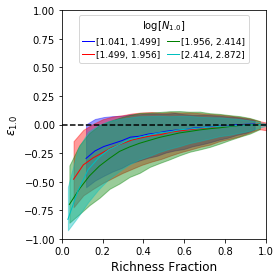

In [12]:
print('\n~~~~~ PLOTTING MARGINALIZED RICHNESS DEPENDANCE AT BINNED RICHNESS ~~~~~~')

f,ax = plt.subplots(figsize=(4,4))

bins = np.linspace(np.log10(data_rich['N1.0'].min()), np.log10(data_rich['N1.0'].max()), par['N_bins'] + 1)
colr = ['b','r','g','c','m','y']

for i in range(par['N_bins']):
    data_bin = data_rich[(np.log10(data_rich['N1.0']) >= bins[i]) & 
                         (np.log10(data_rich['N1.0']) < bins[i+1]) & (data_rich['nbin'])]
    print(len(data_bin))
    if len(data_bin)>0:
        matt.binnedplot(data_bin['rich_frac'], data_bin['err_keras'],
                        n=20, percentiles = [34],
                        median = True, ax=ax, log=0, c= colr[i%len(colr)], names=False,
                        label='[' + str(bins[i])[0:5] + ', ' + str(bins[i+1])[0:5] + ']'
                       )

ax.axhline(y = 0, linestyle='dashed', c = 'k')
ax.set_xlim(0,1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Richness Fraction', fontsize=12)

if par['err_type']=='true':
    ax.set_ylabel('$\epsilon$', fontsize=12)
elif par['err_type'] == 'pred':
    ax.set_ylabel('$\epsilon_{1.0}$', fontsize=12)

plt.legend(fontsize=9, ncol=2, title='$\log[N_{1.0}]$', loc=9,
           handletextpad=0.25, columnspacing=0.75, handlelength=1.3
          )
plt.tight_layout()

f.savefig(os.path.join(imdir,'2d_richmargin_nbin.pdf'),bbox_inches='tight')

# Scratch

In [67]:
import sdm

cat = contam_cat

ind = np.random.choice(range(len(cat)), 
                           int(0.005*len(cat)),
                           replace=False
                          )
cat = cat[ind]

len(cat)

1311

In [76]:
logmass = np.log10(cat.prop['M200c'])
featuresList = [[(j,) for j in np.abs(cat.gal[m]['vlos'])] for m in range(len(cat))]

feats = sdm.Features(featuresList, mass=logmass, default_category='train')
feats, scaler = feats.standardize(ret_scaler=True)

In [77]:
feats.data

array([(array([[-0.09861763],
       [-0.65757708],
       [-0.98661909],
       [ 0.13596518],
       [ 0.60808585],
       [-0.26181607],
       [ 0.19107417],
       [ 0.70798293],
       [-0.15953791],
       [-0.13714293],
       [ 0.26479208],
       [-0.42396032],
       [-0.95870829],
       [-0.26436445],
       [-0.59559972],
       [ 0.15643199],
       [-0.03308387],
       [-0.95742609],
       [-0.12468851],
       [-0.61135581],
       [ 0.31295819],
       [-0.19646679],
       [ 0.56167613],
       [-0.78523568],
       [-0.70186774],
       [-1.01407912],
       [-0.81531473],
       [-0.40152492],
       [-0.24010149],
       [-0.91420876],
       [ 0.47422287],
       [-0.53207913]]), 'train', '0', 13.62384862),
       (array([[ 2.8811569 ],
       [-0.29276848],
       [-0.98569761],
       [ 0.13812518],
       [-0.51199048],
       [ 0.13837869],
       [-0.7131465 ],
       [-0.53881153],
       [-1.00875238],
       [ 2.28583034],
       [-0.34074053],
       [

In [81]:
list(np.random.choice(featuresList,4, replace=False))

[(744.3604553170234,),
 (640.3022927559447,),
 (177.38027057546856,),
 (254.36639552176402,),
 (303.86175640820835,),
 (169.53343679193463,),
 (521.2364259769721,),
 (525.3061882454846,),
 (833.2867333113146,),
 (583.1509634852656,),
 (735.818476701891,),
 (912.9777691559178,),
 (1497.244315460186,),
 (1529.8281428289656,),
 (337.66722475097976,),
 (944.1499028533015,),
 (868.7922945827838,),
 (276.2774492744419,),
 (537.5729462721866,),
 (183.6726022876513,),
 (222.2727948272651,),
 (142.50997982473467,),
 (373.93903948071215,),
 (213.03924694855513,),
 (434.6478159168101,),
 (44.839638222425585,),
 (516.4064539137871,),
 (492.3637839808131,),
 (548.1544397877101,),
 (355.29621108601424,),
 (328.3708208948319,),
 (621.5294646824451,),
 (16.481512144689862,),
 (494.40162892346575,),
 (597.390295247851,),
 (821.9327392379626,),
 (622.040763901183,),
 (867.1862255661208,),
 (33.452178256607034,),
 (479.83300862827156,)]

In [47]:
from sklearn.cross_validation import KFold

In [48]:
halo_folds = KFold(n=len(set(cat.prop['rockstarId'])), n_folds=3, shuffle=True)

In [49]:
model = sdm.NuSDR(n_proc = 3, div_func = 'kl', K=4, progressbar=True)

In [50]:
foldIDList = np.random.randint(0,3, len(cat))
model._tune_folds = [[np.vectorize(x.__contains__)(foldIDList) for x in traintest] \
                             for traintest in halo_folds]

In [61]:
featuresList = [[(j,1) for j in np.abs(cat.gal[m]['vlos'])] for m in range(len(cat))]*3

feats_test = sdm.Features(featuresList, default_category='test')
feats_test = feats_test.standardize(scaler=scaler)

print(len(featuresList))

3933


In [62]:
preds = model.transduct(feats, logmass, feats_test, save_fit=True)

 5,244 of 5,244 (100%) |########################################| Time: 0:00:00
 5,244 of 5,244 (100%) |########################################| Time: 0:00:00
 27,499,536 of 27,499,536 (100%) |##############################| Time: 0:02:38
 960 of 960 (100%) |############################################| Time: 0:00:15


In [56]:
model.predict(feats_test)

 2,622 of 2,622 (100%) |########################################| Time: 0:00:00
 2,622 of 2,622 (100%) |########################################| Time: 0:00:00
 3,437,442 of 3,437,442 (100%) |################################| Time: 0:00:19


ValueError: shapes (2622,2622) and (1311,1311) not aligned: 2622 (dim 1) != 1311 (dim 0)

In [141]:
model_name = 'halo_sdm1d_rich'
model_num = 5

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
sdm_par = sdm_dat['params']


In [142]:
err = np.zeros(len(sdm_dat['x']))

for i in range(len(err)):
    j = np.argwhere((sdm_dat['logmass_test'] == sdm_dat['logmass_test'][i] )&
                    (sdm_dat['x']==1)).flatten()[0]
    
    err[i] = ((10.**sdm_dat['logmass_pred'][i])/(10.**sdm_dat['logmass_pred'][j]))**(1)-1.

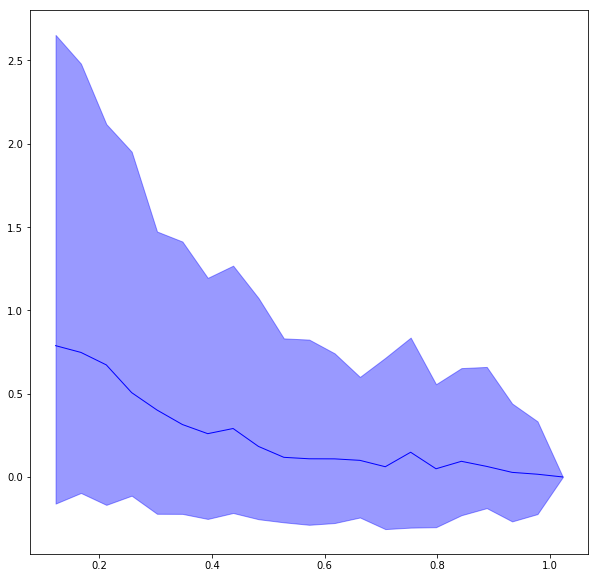

In [143]:
m = matt.binnedplot(sdm_dat['x'], err,
                    n=20, percentiles = [34],
                    median = True, log=0, c='b', label='CNN$_{2D}$', names=False
                   )